# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
# from ACSPaper.Matching import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'metabolomics_model_of_age_and_bmi')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

In [199]:
# from LabData.DataLoaders.NightingaleLoader import NightingaleLoader
# from LabData.DataLoaders.MetabolonLoader import MetabolonLoader

In [2]:
learning_rate = [0.1, 0.05, 0.02, 0.015, 0.01, 0.0075, 0.005, 0.002, 0.001, 0.0005, 0.0001]
num_leaves = range(2, 35)
max_depth = [-1, 2, 3, 4, 5, 10, 20, 40, 50]
min_data_in_leaf = range(1, 45, 2)
feature_fraction = [i / 10. for i in range(2, 11)]  # [1] when using dummy variables
metric = ['l2']
early_stopping_rounds = [None]
# early_stopping_rounds = [10, 20, 50]
num_threads = [1]
verbose = [-1]
silent = [True]
n_estimators = range(100, 500, 50)
bagging_fraction = [i / 10. for i in range(2, 11)]
bagging_freq = [0, 1, 2]
lambda_l1 = [0, 0.001, 0.005, 0.01, 0.1]

# Lasso params
alpha = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]


lightgbm_rscv_space = {'learning_rate': learning_rate, 'max_depth': max_depth,
                       'feature_fraction': feature_fraction, 'num_leaves': num_leaves,
                       'min_data_in_leaf': min_data_in_leaf, 'metric': metric,
                       'early_stopping_rounds': early_stopping_rounds, 'n_estimators': n_estimators,
                       'bagging_fraction': bagging_fraction, 'bagging_freq': bagging_freq,
                       'num_threads': num_threads, 'verbose': verbose, 'silent': silent, 'lambda_l1': lambda_l1}

In [31]:
# k = pnp_data.filter(regex='sSGB__4712').columns[0]
# pnp_data.sort_values(k)[[k, 'FD']].tail(100).FD.to_csv('~/top100FD_sSGB4712.csv')
# k

'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712'

# Load data

In [3]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
# pnp_data = pnp_data[pnp_data.IsGenotek == 0]
acs_data['ACS sample'], pnp_data['ACS sample'] = 1, 0

pnp_data.index = pnp_data.index.astype(str)
acs_data.index = acs_data.index.astype(str)

Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
updated_metabs1 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/updated_metabs1.csv', index_col=0)
circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures/', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)
full_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_full_model/abs_signed_shap.csv', index_col=0)
unknowns_sp = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v5/unknown_pathway_prediction/Supplementary_unknowns_sub_pathways_all_features+shap+levels.csv', index_col=0)

In [5]:
acs_data['combined_outcome'] = acs_data[['Acute MI', 'Acute stroke', 'Acute limb event', 'Unplanned PCI', 'New-onset HF', 'New-onset Afib', 'CV hospitalization including chest pain', 'CV death',]].any(1)
acs_data['Acute_MI_or_Stroke'] = acs_data[['Acute MI', 'Acute stroke']].any(1)
acs_data['Number of vessels involved: 1 vs 3'] = acs_data['Number of vessels involved'].replace({1: 1, 3:0, 2:np.nan})
acs_data['Number of vessels involved: 1 vs 2,3'] = acs_data['Number of vessels involved'].replace({1: 1, 3:0, 2:0})
acs_data['Number of vessels involved: 1,2 vs 3'] = acs_data['Number of vessels involved'].replace({1: 1, 3:0, 2:1})

In [6]:
acs_data['combined_cvd_outcome'] = acs_data[['Acute MI', 'Acute stroke', 'Unplanned PCI', 'CV death',]].any(1)

## metabolon

In [34]:
# metabolon = MetabolonLoader().get_data(study_ids=['PNP1', 'Cardio'], 
#                                        robust_zs=True, clip_outliers_std=5, clip_outliers_or_na='clip', fill_missing_with_min=True, 
#                                        log_transform_base=10, norm_within_run_using_anchors=None, norm_across_run_using_anchors=True, 
#                                        normalize_std=True)

In [35]:
# metabolon.df_metadata.sort_index(inplace=True)
# metabolon.df.sort_index(inplace=True)
# metabolon_df = metabolon.df.reset_index().copy()
# metabolon_df.loc[:, 'RegistrationCode'] = metabolon.df_metadata['RegistrationCode'].values
# metabolon_df.loc[:, 'Date'] = metabolon.df_metadata['StorageDT'].values
# # metabolon_df['metabolon_run'] = metabolon.df_metadata['metabolon_run'].values
# # metabolon_df['StudyTypeID'] = metabolon.df_metadata['StudyTypeID'].values
# metabolon_df = metabolon_df.groupby('RegistrationCode').first().reset_index()
# metabolon_df.set_index(['RegistrationCode', 'Date'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [761]:
# metabolon_df.to_csv(os.path.join(paper_dir, 'data', 'metabolon_df.csv'))

In [7]:
metabolon_df = pd.read_csv(os.path.join(paper_dir, 'data', 'metabolon_df.csv'), index_col=['RegistrationCode'], parse_dates=['Date'])

In [8]:
# # PNP1 17
# pnp1_17_serumname = metabolon.df[(metabolon.df_metadata.StudyTypeID == 1) & (metabolon.df_metadata.metabolon_run == 'Metabolon_MAR2017')].index
# # PNP1 18
# pnp1_18_serumname = metabolon.df[(metabolon.df_metadata.StudyTypeID == 1) & (metabolon.df_metadata.metabolon_run == 'Metabolon_MAY2018')].index
# # ACS
# acs_18_serumname = metabolon.df[(metabolon.df_metadata.StudyTypeID == 8) & (metabolon.df_metadata.metabolon_run == 'Metabolon_MAY2018')].index

# pnp1_17_18_diffs = metabolon.df.apply(lambda x: mannwhitneyu(x.loc[pnp1_17_serumname], x.loc[pnp1_18_serumname])[1])
# plt.hist(np.log10(pnp1_17_18_diffs), bins=20)
# print ((pnp1_17_18_diffs < 0.05/pnp1_17_18_diffs.shape[0]).sum())
# problematic_batch_molecules = pnp1_17_18_diffs[pnp1_17_18_diffs < 0.05/pnp1_17_18_diffs.shape[0]].index.tolist()
# problematic_batch_molecules

In [9]:
# bad_molecules = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/bad_molecules.csv', index_col=0).loc[:, '0'].tolist()
# bad_molecules = list(set(metabolon_df.columns).intersection(set(bad_molecules)))
# bad_molecules

In [41]:
# metabolon_molecules_to_remove = list(set(bad_molecules).union(set(problematic_batch_molecules)))
# print (len(metabolon_molecules_to_remove))

NameError: name 'problematic_batch_molecules' is not defined

In [720]:
# with open(os.path.join(paper_dir, 'metabolon_molecules_to_remove.pkl'), 'wb') as handle:
#     pickle.dump(metabolon_molecules_to_remove, handle)

In [31]:
with open(os.path.join(paper_dir, 'metabolon_molecules_to_remove.pkl'), 'rb') as handle:
    metabolon_molecules_to_remove = pickle.load(handle)

In [43]:
storage_bad_metabs = pd.read_pickle(os.path.join('../data', 'storage_time_bad_metabs_bonf.pkl'))

In [44]:
metabolon_molecules_to_remove = storage_bad_metabs

In [45]:
# metabolon_molecules_to_remove = list(set(metabolon_molecules_to_remove).union(set(storage_bad_metabs)))
print(len(metabolon_molecules_to_remove))

25


## nightingale

In [14]:
# nightingale = NightingaleLoader().get_data(study_ids=['PNP1', 'Cardio'])
# # nightingale.df = nightingale.df.replace('TAG', np.nan).astype(float)

# nightingale.df_metadata.sort_index(inplace=True)
# nightingale.df.sort_index(inplace=True)
# nightingale_df = nightingale.df.reset_index().copy()
# nightingale_df.loc[:, 'RegistrationCode'] = nightingale.df_metadata['RegistrationCode'].values
# nightingale_df.loc[:, 'Date'] = nightingale.df_metadata['Date'].values
# nightingale_df = nightingale_df.groupby('RegistrationCode').first().reset_index()
# nightingale_df.set_index(['RegistrationCode', 'Date'], inplace=True)
# nightingale_df

TypeError: cannot unpack non-iterable NoneType object

In [1179]:
# nightingale.metabolites.to_csv(os.path.join(paper_dir, 'data', 'nightingale_metabolite_metadata.csv'))

In [14]:
nightingale_metabolites = pd.read_csv(os.path.join(paper_dir, 'data', 'nightingale_metabolite_metadata.csv'), index_col=0)
nightingale_metabolites

,Biomarker name,Excel column name,Group,Subgroup,Unit,nightingale_run,nightingale_run_id
markers,,,,,,,
Acetate,Acetate,Acetate,Ketone bodies,NaN,mmol/l,Nightingale_Sep2019,0
Acetoacetate,Acetoacetate,Acetoacetate,Ketone bodies,NaN,mmol/l,Nightingale_Sep2019,0
Ala,Alanine,Ala,Amino acids,NaN,mmol/l,Nightingale_Sep2019,0
Albumin,Albumin,Albumin,Fluid balance,NaN,signal area,Nightingale_Sep2019,0
ApoA1,Apolipoprotein A1,ApoA1,Apolipoproteins,NaN,g/l,Nightingale_Sep2019,0
...,...,...,...,...,...,...,...
XXL_VLDL_PL,Phospholipids in chylomicrons and extremely la...,XXL-VLDL-PL,Lipoprotein subclasses,Chylomicrons and extremely large VLDL,mmol/l,Nightingale_Sep2019,0
XXL_VLDL_PL_pct,Phospholipids to total lipids ratio in chylomi...,XXL-VLDL-PL %,Relative lipoprotein lipid concentrations,Chylomicrons and extremely large VLDL ratios,%,Nightingale_Sep2019,0
XXL_VLDL_TG,Triglycerides in chylomicrons and extremely la...,XXL-VLDL-TG,Lipoprotein subclasses,Chylomicrons and extremely large VLDL,mmol/l,Nightingale_Sep2019,0


In [27]:
# nightingale_metabolite_group_dic = nightingale.metabolites['Group'].to_dict()
# for col in nightingale.metabolites.index:
#     nightingale_metabolite_group_dic['TAG_'+col] = nightingale_metabolite_group_dic[col]
# nightingale_metabolite_group_dic

{'Acetate': 'Ketone bodies',
 'Acetoacetate': 'Ketone bodies',
 'Ala': 'Amino acids',
 'Albumin': 'Fluid balance',
 'ApoA1': 'Apolipoproteins',
 'ApoB': 'Apolipoproteins',
 'ApoB_by_ApoA1': 'Apolipoproteins',
 'Cholines': 'Glycerides and phospholipids',
 'Citrate': 'Glycolysis related metabolites',
 'Creatinine': 'Fluid balance',
 'DHA': 'Fatty acids',
 'DHA_pct': 'Fatty acids',
 'Esterified_C': 'Cholesterol',
 'Free_C': 'Cholesterol',
 'Gln': 'Amino acids',
 'Glucose': 'Glycolysis related metabolites',
 'Gly': 'Amino acids',
 'GlycA': 'Inflammation',
 'Glycerol': 'Glycolysis related metabolites',
 'HDL2_C': 'Cholesterol',
 'HDL3_C': 'Cholesterol',
 'HDL_C': 'Cholesterol',
 'HDL_TG': 'Glycerides and phospholipids',
 'HDL_size': 'Lipoprotein particle sizes',
 'His': 'Amino acids',
 'IDL_C': 'Lipoprotein subclasses',
 'IDL_CE': 'Lipoprotein subclasses',
 'IDL_CE_pct': 'Relative lipoprotein lipid concentrations',
 'IDL_C_pct': 'Relative lipoprotein lipid concentrations',
 'IDL_FC': 'Lipop

In [28]:
# nightingale_metabolite_name_dic = nightingale.metabolites['Biomarker name'].to_dict()
# for col in nightingale.metabolites.index:
#     nightingale_metabolite_name_dic['TAG_'+col] = nightingale_metabolite_name_dic[col]
# nightingale_metabolite_name_dic

{'Acetate': 'Acetate',
 'Acetoacetate': 'Acetoacetate',
 'Ala': 'Alanine',
 'Albumin': 'Albumin',
 'ApoA1': 'Apolipoprotein A1',
 'ApoB': 'Apolipoprotein B',
 'ApoB_by_ApoA1': 'Ratio of apolipoprotein B to apolipoprotein A1',
 'Cholines': 'Total cholines',
 'Citrate': 'Citrate',
 'Creatinine': 'Creatinine',
 'DHA': 'Docosahexaenoic acid',
 'DHA_pct': 'Ratio of docosahexaenoic acid to total fatty acids',
 'Esterified_C': 'Total esterified cholesterol',
 'Free_C': 'Total free cholesterol',
 'Gln': 'Glutamine',
 'Glucose': 'Glucose',
 'Gly': 'Glycine',
 'GlycA': 'Glycoprotein acetyls',
 'Glycerol': 'Glycerol',
 'HDL2_C': 'HDL2 cholesterol',
 'HDL3_C': 'HDL3 cholesterol',
 'HDL_C': 'HDL cholesterol',
 'HDL_TG': 'Triglycerides in HDL',
 'HDL_size': 'Average diameter for HDL particles',
 'His': 'Histidine',
 'IDL_C': 'Cholesterol in IDL',
 'IDL_CE': 'Cholesteryl esters in IDL',
 'IDL_CE_pct': 'Cholesteryl esters to total lipids ratio in IDL',
 'IDL_C_pct': 'Cholesterol to total lipids ratio 

## merge data

In [29]:
# print (pnp_data.shape, acs_data.shape)
# pnp_data_metabolon = pnp_data.merge(metabolon_df, on='RegistrationCode', how='left')
# acs_data_metabolon = acs_data.merge(metabolon_df, on='RegistrationCode', how='left')
# acs_data_metabolon['const'] = 1
# print (pnp_data_metabolon.shape, acs_data_metabolon.shape)

# data = pd.concat((pnp_data_metabolon, acs_data_metabolon), axis=0, sort=False)
# print (data.shape)
# data = data.reindex(nightingale_df.columns.tolist() + metabolon_df.columns.tolist() + ['Age', 'gender', 'bmi', 'ACS sample'], axis=1).dropna(how='all', axis=1).dropna(how='all', axis=0)
# print (data.shape)

# assert data.index.unique().shape == data.index.shape

(985, 3478) (202, 3461)
(985, 4440) (202, 4424)
(1187, 4688)
(1187, 1193)


In [760]:
# pnp_data_metabolon.to_csv(os.path.join(paper_dir, 'data', 'pnp_data_metabolon.csv'))
# acs_data_metabolon.to_csv(os.path.join(paper_dir, 'data', 'acs_data_metabolon.csv'))

In [47]:
pnp_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data', 'pnp_data_metabolon.csv')).drop('Date', axis=1)
pnp_data_metabolon['RegistrationCode'] = pnp_data_metabolon['RegistrationCode'].astype(str)
pnp_data_metabolon.set_index(['RegistrationCode'], inplace=True)
acs_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data', 'acs_data_metabolon.csv')).drop('Date', axis=1)
acs_data_metabolon['RegistrationCode'] = acs_data_metabolon['RegistrationCode'].astype(str)
acs_data_metabolon.set_index(['RegistrationCode'], inplace=True)

data = pd.concat((pnp_data_metabolon, acs_data_metabolon), axis=0, sort=False)
print (data.shape)
data = data.reindex(nightingale_metabolites.index.tolist() + metabolon_df.columns.tolist() + ['Age', 'gender', 'bmi', 'ACS sample'], axis=1).dropna(how='all', axis=1).dropna(how='all', axis=0)
print (data.shape)

Columns (43,3236,3261) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (1,10,23,30,40,96,107,110,111,112,131,132,133,134,135,136,137,138,139,140,141,142,143,145,148,149,150,151,152,153,155,157,159,169,170,179,184,3212) have mixed types.Specify dtype option on import or set low_memory=False.


(1187, 4679)
(1187, 1193)


# Predictive models

In [48]:
healthy_real_age = data[data['ACS sample'] == 0]['Age']
healthy_real_sex = data[data['ACS sample'] == 0]['gender']
healthy_real_bmi = data[data['ACS sample'] == 0]['bmi']
healthy_pred_age_sex_bmi = pd.DataFrame(np.nan, index=data[data['ACS sample'] == 0].index, columns=['Age', 'gender', 'bmi'])

acs_real_age = data[data['ACS sample'] == 1]['Age']
acs_real_sex = data[data['ACS sample'] == 1]['gender']
acs_real_bmi = data[data['ACS sample'] == 1]['bmi']
acs_pred_age_sex_bmi = pd.DataFrame(0, index=data[data['ACS sample'] == 1].index, columns=['Age', 'gender', 'bmi'])

y_age = healthy_real_age.dropna().copy()
# y_age = y_age[y_age > 40]
y_sex = healthy_real_sex.dropna().copy()
y_bmi = healthy_real_bmi.dropna().copy()


## GBDT

In [49]:
make_dir_if_not_exists(os.path.join(curr_dir, 'GBDT'))

In [87]:
import shap
print ('shap', shap.__version__)
import sklearn
print ('sklearn', sklearn.__version__)

shap 0.35.0
sklearn 0.23.2


### train-test

In [50]:
gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine')

In [51]:
# nightingale_molecules_to_remove = ['Albumin']
nightingale_molecules_to_remove = ['Albumin', 'Glucose', 'Creatinine', 'TAG_Creatinine']
# nightingale_molecules_to_remove = []
# temp_X.drop(nightingale_molecules_to_remove, axis=1)

In [52]:
# gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test')
# gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin')
gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine')
make_dir_if_not_exists(gbdt_dir)
# in each fold learn on the 4/5 healthy and predict the fold of healthy, and add age predictions to the acs as well.
models, healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict, acs_Xs, healthy_Xs, healthy_shap_values_dic, acs_shap_values_dic = {}, {}, {}, {}, {}, {}, {}

for data_name, data_cols in zip(['metabolon', 'nightingale', 'metabolon+nightingale'], 
                                [metabolon_df.columns.tolist(), nightingale_metabolites.index.tolist(), 
                                 metabolon_df.columns.tolist() + nightingale_metabolites.index.tolist()]):
    if data_name != 'metabolon':
        break
    print (data_name)
    temp_data = data.reindex(data_cols + ['ACS sample'], axis=1).dropna(how='all', axis=1).copy()
    temp_data = temp_data.loc[temp_data.notnull().sum(1)>temp_data.shape[1]/2, :]
    make_dir_if_not_exists(os.path.join(gbdt_dir, data_name))
    X_healthy = temp_data.loc[temp_data[temp_data['ACS sample'] == 0].index].reindex(data_cols, axis=1).dropna(how='all', axis=1).copy()
    X_tag = add_null_indicator_column(X_healthy, null='TAG', fillna=0, prefix='TAG').astype(float)
#     X_not_null = add_null_indicator_column(X_tag, fillna=0, prefix='null')
    X_not_null = X_tag

    X_acs = temp_data.loc[temp_data[temp_data['ACS sample'] == 1].index].reindex(data_cols, axis=1).dropna(how='all', axis=1).copy()
    X_acs_tag = add_null_indicator_column(X_acs, null='TAG', fillna=0, prefix='TAG').astype(float)
#     X_acs_not_null = add_null_indicator_column(X_acs_tag, fillna=0, prefix='null')
    X_acs_not_null = X_acs_tag

    X_not_null, X_acs_not_null = pd.concat((X_not_null, X_acs_not_null), axis=0).fillna(0).loc[X_not_null.index], pd.concat((X_not_null, X_acs_not_null), axis=0).fillna(0).loc[X_acs_not_null.index]

    acs_pred_age_sex_bmi.loc[:, :] = np.nan
    healthy_pred_age_sex_bmi.loc[:, :] = np.nan
    
    temp_X = X_not_null.copy()
    temp_X_acs = X_acs_not_null.copy()
    if 'metabolon' in data_name:
        temp_X = temp_X.drop(metabolon_molecules_to_remove, axis=1)
        temp_X_acs = temp_X_acs.drop(metabolon_molecules_to_remove, axis=1).copy()
#         continue
    if 'nightingale' in data_name:
        temp_X = temp_X.drop(nightingale_molecules_to_remove, axis=1)
        temp_X_acs = temp_X_acs.drop(nightingale_molecules_to_remove, axis=1).copy()
        
    print ('healthy X', temp_X.shape, 'ACS X', temp_X_acs.shape)
    acs_Xs[data_name] = temp_X_acs.copy()
    healthy_Xs[data_name] = {}
    
    healthy_shap_values_dic[data_name] = {}
    acs_shap_values_dic[data_name] = {}
    
    models[data_name] = {}

    for target, X, y, mode in zip(['Age', 'gender', 'bmi'], 
                                  [temp_X.merge(y_age, on='RegistrationCode').drop('Age', axis=1),  # y_age[y_age>=40]
                                   temp_X.merge(y_sex, on='RegistrationCode').drop('gender', axis=1), 
                                   temp_X.merge(y_bmi, on='RegistrationCode').drop('bmi', axis=1)],
#                                   [temp_X.loc[y_age.index], temp_X.loc[y_sex.index], temp_X.loc[y_bmi.index]], 
                                  [temp_X.merge(y_age, on='RegistrationCode')['Age'], temp_X.merge(y_sex, on='RegistrationCode')['gender'], temp_X.merge(y_bmi, on='RegistrationCode')['bmi']],  # y_age[y_age>=40]
                                  ['cont', 'bin', 'cont']):
        healthy_Xs[data_name][target] = X.copy()
        
        acs_shap_values_dic[data_name][target] = pd.DataFrame(0, index=temp_X_acs.index, columns=temp_X_acs.columns)
        print (target, mode, X.shape)
        if target == 'gender':
            continue

        train_idx, test_idx = train_test_split(X.index, test_size=temp_X_acs.shape[0], random_state=0)
        X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
        print ('train-test shapes:', X_train.shape, X_test.shape)
        healthy_shap_values_dic[data_name][target] = pd.DataFrame(np.nan, index=X_test.index, columns=X_test.columns)

        if mode == 'cont':
            model = lgb.LGBMRegressor()
            rscv = RandomizedSearchCV(model, lightgbm_rscv_space, n_iter=5, cv=3)
#             x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#             rscv.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='l2')
            rscv.fit(X_train, y_train)

            y_pred = rscv.best_estimator_.predict(X_test)
            healthy_pred_age_sex_bmi.loc[X_test.index, target] = y_pred

            y_pred = rscv.best_estimator_.predict(temp_X_acs)
            acs_pred_age_sex_bmi.loc[temp_X_acs.index, target] = y_pred

            explainer = shap.TreeExplainer(rscv.best_estimator_)
            try:
                # changed on 3.10.2018, last column is the bias column
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)
            except:
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)[:, :-1]
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)[:, :-1]

    
    healthy_pred_age_sex_bmi.to_csv(os.path.join(gbdt_dir, data_name, 'healthy_pred_age_sex_bmi.csv'))
    acs_pred_age_sex_bmi = acs_pred_age_sex_bmi.replace(0, np.nan)
    acs_pred_age_sex_bmi.to_csv(os.path.join(gbdt_dir, data_name, 'acs_pred_age_sex_bmi.csv'))
    healthy_pred_age_sex_bmi_dict[data_name] = healthy_pred_age_sex_bmi.copy()
    acs_pred_age_sex_bmi_dict[data_name] = acs_pred_age_sex_bmi.copy()
with open(os.path.join(gbdt_dir, 'models.pkl'), 'wb') as handle:
    pickle.dump(models, handle)
with open(os.path.join(gbdt_dir, 'acs_Xs.pkl'), 'wb') as handle:
    pickle.dump(acs_Xs, handle)
with open(os.path.join(gbdt_dir, 'healthy_Xs.pkl'), 'wb') as handle:
    pickle.dump(healthy_Xs, handle)
with open(os.path.join(gbdt_dir, 'acs_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(acs_shap_values_dic, handle)
with open(os.path.join(gbdt_dir, 'healthy_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(healthy_shap_values_dic, handle)

metabolon
healthy X (474, 936) ACS X (156, 936)
Age cont (471, 936)
train-test shapes: (315, 936) (156, 936)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

gender bin (474, 936)
bmi cont (454, 936)
train-test shapes: (298, 936) (156, 936)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

In [178]:
# with open(os.path.join(os.path.join('../metabolomics_model_of_age_and_bmi/', 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine'), 'healthy_shap_values_dic.pkl'), 'rb') as handle:
#     healthy_shap_values_dic_old = pickle.load(handle)
# with open(os.path.join(os.path.join('../metabolomics_model_of_age_and_bmi/', 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine'), 'healthy_Xs.pkl'), 'rb') as handle:
#     healthy_Xs_old = pickle.load(handle)

In [219]:
gbdt_dir = os.path.join(curr_dir, 'GBDT', 'Train-Test', 'no-albumin-glucose-creatinine')
healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict = {}, {}
for d in ['metabolon', 'nightingale', 'metabolon+nightingale']:
    healthy_pred_age_sex_bmi_dict[d] = pd.read_csv(os.path.join(gbdt_dir, d, 'healthy_pred_age_sex_bmi.csv'), index_col=0)
    acs_pred_age_sex_bmi_dict[d] = pd.read_csv(os.path.join(gbdt_dir, d, 'acs_pred_age_sex_bmi.csv'), index_col=0)
with open(os.path.join(gbdt_dir, 'acs_shap_values_dic.pkl'), 'rb') as handle:
    acs_shap_values_dic = pickle.load(handle)
with open(os.path.join(gbdt_dir, 'healthy_shap_values_dic.pkl'), 'rb') as handle:
    healthy_shap_values_dic = pickle.load(handle)

In [97]:
acs_shap_values_dic['metabolon']['bmi'].to_csv(os.path.join(gbdt_dir, 'metabolon', 'acs_shap_values_dic_metabolon_bmi.csv'))

metabolon


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


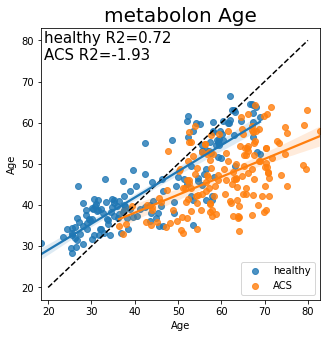

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


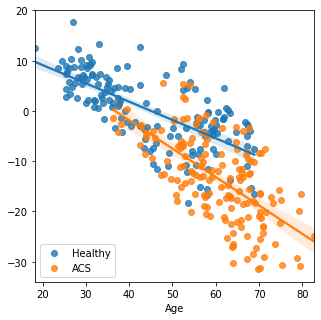

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


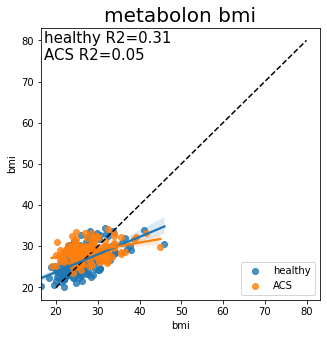

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


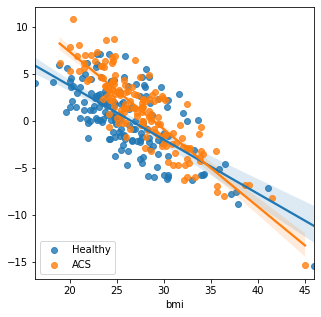

nightingale


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


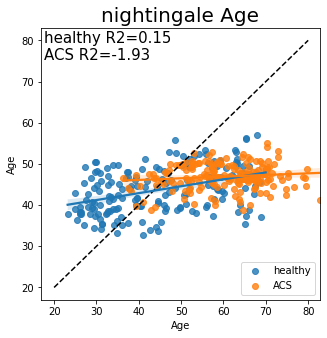

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


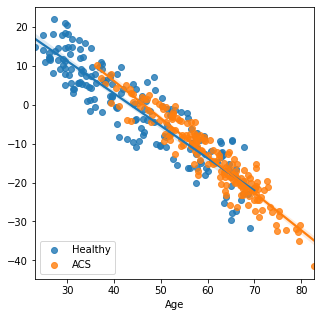

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


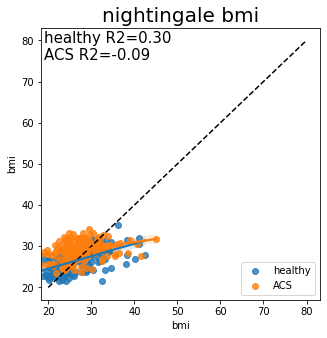

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


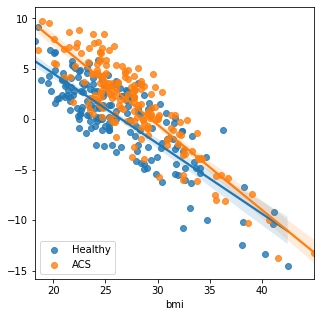

metabolon+nightingale


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


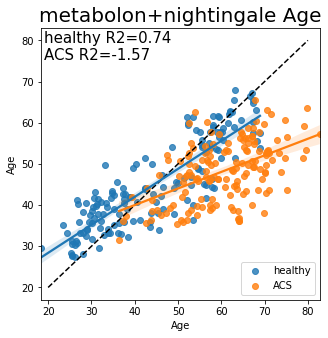

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


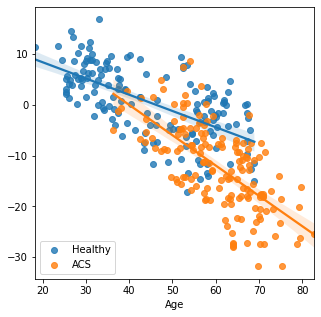

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


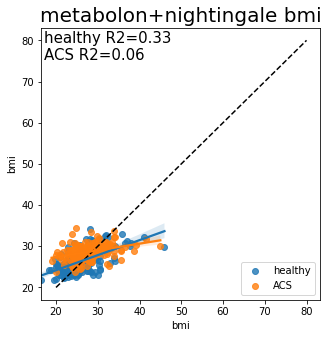

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


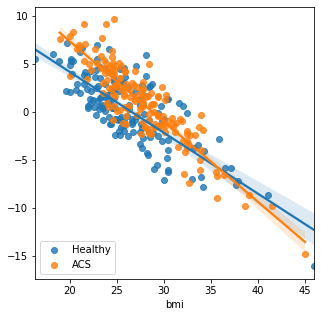

In [288]:
for data_name in healthy_pred_age_sex_bmi_dict:
    print (data_name)
    for target, healthy_y, acs_y in zip(['Age', 'bmi'], [healthy_real_age, healthy_real_bmi], [acs_real_age, acs_real_bmi]):
        healthy_r2 = r2_score_rmna(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target])
        acs_r2 = r2_score_rmna(acs_y, acs_pred_age_sex_bmi_dict[data_name][target])
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot([20, 80], [20, 80], '--', color='black')
        sns.regplot(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target], label='healthy')
        sns.regplot(acs_y, acs_pred_age_sex_bmi_dict[data_name][target], label='ACS')
        add_text_at_corner(ax, 'healthy R2=%0.2f\nACS R2=%0.2f'%(healthy_r2, acs_r2), 'top left', fontsize=15)
        ax.set_title(data_name + ' ' + target, fontsize=20)
        ax.legend(loc='lower right')
        plt.show()
        
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        healthy_diffs = healthy_pred_age_sex_bmi_dict[data_name][target].values - healthy_y.values
        acs_diffs = acs_pred_age_sex_bmi_dict[data_name][target].values - acs_y.values
        sns.regplot(healthy_y, healthy_diffs, label='Healthy')
        sns.regplot(acs_y, acs_diffs, label='ACS')
        ax.legend(loc='lower left')
        plt.show()

#### correlate diffs with clinical params

In [96]:
acs_real_bmi - acs_pred_age_sex_bmi_dict['metabolon']['bmi'].reindex(acs_real_bmi.index)
acs_bmi_diffs = pd.Series(acs_pred_age_sex_bmi_dict['metabolon']['bmi'].values - acs_real_bmi.values, index=acs_real_bmi.index, name='acs bmi diffs')
acs_data.loc[acs_bmi_diffs.index, 'acs bmi diffs'] = acs_bmi_diffs.values
acs_data['const'] = 1
c = 'Number of vessels involved: 1 vs 3'
spearmanr(acs_data.loc[acs_bmi_diffs.index, c], acs_bmi_diffs, nan_policy='omit')

SpearmanrResult(correlation=-0.06980264602646527, pvalue=0.4749579214304316)

In [95]:
spearmanr(acs_data['Glucose Disorder: DM2'], acs_data['Number of vessels involved'], nan_policy='omit')

SpearmanrResult(correlation=0.1416569840442442, pvalue=0.04486310615710625)

In [268]:
ps = acs_shap_values_dic['metabolon']['bmi'].reindex(data.index).apply(lambda x: OLS(acs_data.reindex(data.index)['acs bmi diffs'], 
                                                                 pd.concat((acs_data.reindex(data.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().pvalues.loc[x.name])
rs = acs_shap_values_dic['metabolon']['bmi'].reindex(data.index).apply(lambda x: OLS(acs_data.reindex(data.index)['acs bmi diffs'], 
                                                                 pd.concat((acs_data.reindex(data.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, 
                                                                           sort=False), missing='drop').fit().params.loc[x.name])
rs.dropna().sort_values().head(30)

100001502   -423.920358
564         -416.914707
100004329   -381.604920
821         -374.742815
100002528   -288.953241
100009130   -288.893685
93          -287.420569
424         -270.315088
100002927   -260.942956
482         -258.987586
100001263   -249.127830
X - 12726   -232.983166
100004575   -224.421773
892         -193.858606
1629        -192.025494
415         -163.507847
100000841   -160.083820
100001229   -154.558147
X - 18913   -143.696035
100015792   -133.548826
100000846   -126.787066
1024        -125.022198
100000015   -118.335639
X - 24811   -117.060283
409         -113.517673
100002761   -107.220478
100020842   -105.400430
X - 11880   -103.019496
100000295    -96.807663
100019794    -93.730436
dtype: float64

In [293]:
fdr_correction(ps.dropna(), alpha=0.1)[0].sum()#.sort_values().head(20)

31

# Plot

In [23]:
def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

In [24]:
import statsmodels
statsmodels.__version__

'0.12.1'

In [99]:
# data = acs_data[(acs_data['bmi']<30) & (acs_data['Glucose Disorder: DM2'] == 0) & (acs_data['Glucose Disorder: DM1'] == 0)].copy()
data = acs_data[(acs_data['bmi']<30)]
data = acs_data.dropna(subset=['acs bmi diffs']).copy()
data['Number of vessels involved: 1 vs 3'] = data['Number of vessels involved: 1 vs 3'].replace({0:1, 1:0})
# print(data.shape)
covariates = ['bmi', 'const', 'Age']
# covariates = ['bmi', 'const', 'Age']
col = 'acs bmi diffs'
use_covariates = True
ys = ['Number of vessels involved: 1 vs 3', 'Known CAD', 
      'Number of vessels involved: 1 vs 2,3', 'Number of vessels involved: 1,2 vs 3', 'combined_cvd_outcome']
data['const'] = 1

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=ys, columns=columns)

for y in tqdm_notebook(ys):
    if covariates:
        try:
            log = Logit(data[y].astype(float), 
                                    data.reindex([col] + covariates, axis=1), missing='drop').fit(disp=0)
            logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
    
covariates = ['bmi', 'const', 'Age']
ys = ['Glucose Disorder: DM2']

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']

for y in tqdm_notebook(ys):
    if covariates:
        try:
            log = Logit(data[y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            logit_results.loc[y, '0.025'], logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
logit_results = logit_results.dropna()
logit_results

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,coef,pval,0.025,0.975,log
Number of vessels involved: 1 vs 3,1.34237,0.0345809,1.02158,1.76389,<statsmodels.discrete.discrete_model.BinaryRes...
Known CAD,0.966925,0.746077,0.788823,1.18524,<statsmodels.discrete.discrete_model.BinaryRes...
"Number of vessels involved: 1 vs 2,3",0.843258,0.0863467,0.693976,1.02465,<statsmodels.discrete.discrete_model.BinaryRes...
"Number of vessels involved: 1,2 vs 3",0.796679,0.0508734,0.63415,1.00086,<statsmodels.discrete.discrete_model.BinaryRes...
combined_cvd_outcome,0.884722,0.443343,0.646846,1.21008,<statsmodels.discrete.discrete_model.BinaryRes...
Glucose Disorder: DM2,1.43602,0.00164036,1.14639,1.79883,<statsmodels.discrete.discrete_model.BinaryRes...


In [90]:
print ('ACS real-predicted pearson', pearsonr_rmna(acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']))
print ('Healthy real-predicted pearson', pearsonr_rmna(healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']))

ACS real-predicted pearson (0.37416683572791404, 1.496461457807762e-06)
Healthy real-predicted pearson (0.5887315557738934, 6.324149339622402e-16)


In [58]:
pearsonr_rmna(healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi'])

(0.5887315557738934, 6.324149339622402e-16)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


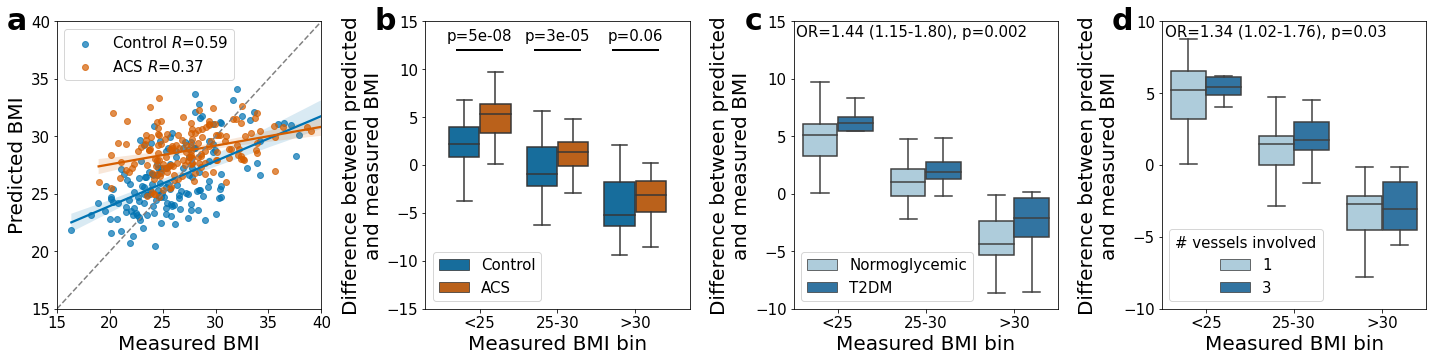

In [101]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'



age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Control %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=healthy_real_bmi.index.tolist() + acs_real_bmi.index.tolist(), columns=['x', 'y', 'z'])
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].values - healthy_real_bmi.values
df.loc[healthy_real_bmi.index, 'x'] = y.values
df.loc[healthy_real_bmi.index, 'y'] = yy
df.loc[healthy_real_bmi.index, 'z'] = 'Control'
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon'].loc[:, 'bmi'].values - acs_real_bmi.values
df.loc[acs_real_bmi.index, 'x'] = y.values
df.loc[acs_real_bmi.index, 'y'] = yy
df.loc[acs_real_bmi.index, 'z'] = 'ACS'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[healthy_color, acs_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-15, 15))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'Control') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'ACS') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 13,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=12, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')

ax = axes[2]
c = 'Glucose Disorder: DM2'
data['bmi bin'] = pd.cut(data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bmi bin', y='acs bmi diffs', data=data.sort_values('bmi').replace({c:{0:'Normoglycemic', 1:'T2DM'}}), ax=ax, palette=colors, hue=c, showfliers=False)
ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='')
leg.get_title().set_fontsize(str(tick_fontsize))
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([-10, -5, 0, 5, 10, 15])
add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)    
    
ax = axes[3]
c = 'Number of vessels involved: 1 vs 3'
data['bmi bin'] = pd.cut(data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bmi bin', y='acs bmi diffs', data=data.sort_values('bmi').replace({c:{0:'1', 1:'3'}}), ax=ax, palette=colors, hue=c, showfliers=False)
ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='# vessels involved')
leg.get_title().set_fontsize(str(tick_fontsize))
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([-10, -5, 0, 5, 10])
add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)


fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'd', ha='center', va='center', transform=axes[3].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(gbdt_dir, 'Figure4.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'Figure4.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(gbdt_dir, 'Figure4.png'), dpi=1000, bbox_inches='tight')

In [94]:
bmi_diff_bins.groupby(['z', 'bin']).mean()

x         y
z       bin                       
ACS     25-30  27.380931  1.255492
        <25    23.255760  5.083593
        >30    33.322315 -3.644934
Control 25-30  27.277164 -0.410500
        <25    22.629178  2.318622
        >30    33.890557 -4.646209

## supp table - shap drivers

In [62]:
ps = acs_shap_values_dic['metabolon']['bmi'].reindex(data.index).apply(lambda x: OLS(acs_data.reindex(data.index)['acs bmi diffs'], 
                                                                 pd.concat((acs_data.reindex(data.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, sort=False), missing='drop').fit().pvalues.loc[x.name])
rs = acs_shap_values_dic['metabolon']['bmi'].reindex(data.index).apply(lambda x: OLS(acs_data.reindex(data.index)['acs bmi diffs'], 
                                                                 pd.concat((acs_data.reindex(data.index)[['bmi', 'const', 'Glucose Disorder: DM2']], x), axis=1, sort=False), missing='drop').fit().params.loc[x.name])
fdr_correction(ps.dropna(), alpha=0.1)[0].sum()

36

In [78]:
df = pd.concat((ps.sort_values().dropna().rename('SHAP-delta BMI pvalue'), rs.rename('SHAP-delta BMI coef'), circ_heatmap_df_sorted,
          pnp_data_metabolon.loc[:, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, pnp_data_metabolon['bmi'], nan_policy='omit')[0]).rename('metabolite-BMI in healthy cohort Spearman rho'),
          acs_data_metabolon.loc[data.index, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, data['Glucose Disorder: DM2'], nan_policy='omit')[0]).rename('metabolite-Glucose Disorder: DM2 Spearman rho'),
          acs_data_metabolon.loc[data.index, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, data['Glucose Disorder: DM2'], nan_policy='omit')[1]).rename('metabolite-Glucose Disorder: DM2 Spearman pvalue'),   
          acs_data_metabolon.loc[data.index, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, data['Number of vessels involved: 1 vs 3'], nan_policy='omit')[0]).rename('metabolite-Number of vessels involved: 1, 3 Spearman rho'),
          acs_data_metabolon.loc[data.index, ps.sort_values().dropna().index].apply(lambda x: spearmanr(x, data['Number of vessels involved: 1 vs 3'], nan_policy='omit')[1]).rename('metabolite-Number of vessels involved: 1, 3 Spearman pvalue'), 
          acs_data_metabolon.loc[data.index, ps.sort_values().dropna().index].apply(lambda x: mannwhitneyu(x.loc[data[data['Number of vessels involved: 1 vs 3']==0].index].dropna(), x.loc[data[data['Number of vessels involved: 1 vs 3']==1].index].dropna())[1]).rename('metabolite-Number of vessels involved: 1, 3 MWU pvalue')),
          axis=1).dropna().rename_axis('CHEMICAL_ID')
df['SHAP-delta BMI qvalue'] = fdr_correction(df['SHAP-delta BMI pvalue'])[1]
df[df['SHAP-delta BMI qvalue']<0.01].to_csv(os.path.join(gbdt_dir, 'Supplementary_table_metabolon_bmi_shap_drivers.csv'))

In [81]:
df.loc[['100001395', '100009009', '100009007']]

,SHAP-delta BMI pvalue,SHAP-delta BMI coef,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,metabolite-BMI in healthy cohort Spearman rho,metabolite-Glucose Disorder: DM2 Spearman rho,metabolite-Glucose Disorder: DM2 Spearman pvalue,"metabolite-Number of vessels involved: 1, 3 Spearman rho","metabolite-Number of vessels involved: 1, 3 Spearman pvalue","metabolite-Number of vessels involved: 1, 3 MWU pvalue",SHAP-delta BMI qvalue
CHEMICAL_ID,,,,,,,,,,,,,,,
100001395,0.015367,4.574019,-9.528168,-1.118011,0.000000,0.060318,0.078544,0.0,-0.288922,-0.103296,0.200884,-0.205566,0.033657,0.017295,0.125145
100009009,0.000072,3.735762,0.053610,-1.947881,0.006287,0.018604,0.132500,0.0,-0.367762,-0.183246,0.022472,-0.218373,0.023841,0.012384,0.004574
100009007,0.000006,1.724924,-0.303066,-3.347978,0.039652,0.063258,0.223122,0.0,-0.412105,-0.255201,0.001352,-0.115270,0.237084,0.118308,0.001841


In [80]:
updated_metabs1.loc[['100001395', '100009009', '100009007', '803']] # 100001395, 100009009

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
CHEMICAL_ID,,,,,,,,,,,,,,,
100001395,34419,HMDB10386,NaN,1-linoleoyl-GPC (18:2),NaN,10160888.0,C04100,520.33977,1947.0,LC/MS Pos Late,11988421.0,1465.0,Lysophospholipid,Lipid,1-linoleoyl-GPC (18:2)
100009009,52682,HMDB11211,NaN,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...,NaN,24767486.0,NaN,742.57452,2132.0,LC/MS Pos Late,NaN,2226.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...
100009007,52478,NaN,NaN,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,NaN,NaN,NaN,744.59017,2125.0,LC/MS Pos Late,NaN,2443.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*
803,48153,HMDB00169,NaN,mannose,3458-28-4,141983.0,C00159,225.06159,992.0,LC/MS Polar,18950.0,2200.0,"Fructose, Mannose and Galactose Metabolism",Carbohydrate,mannose


In [79]:
df.head(30)

,SHAP-delta BMI pvalue,SHAP-delta BMI coef,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,metabolite-BMI in healthy cohort Spearman rho,metabolite-Glucose Disorder: DM2 Spearman rho,metabolite-Glucose Disorder: DM2 Spearman pvalue,"metabolite-Number of vessels involved: 1, 3 Spearman rho","metabolite-Number of vessels involved: 1, 3 Spearman pvalue","metabolite-Number of vessels involved: 1, 3 MWU pvalue",SHAP-delta BMI qvalue
CHEMICAL_ID,,,,,,,,,,,,,,,
100009007,0.000006,1.724924,-0.303066,-3.347978,0.039652,0.063258,0.223122,0.000000,-0.412105,-0.255201,1.351803e-03,-0.115270,0.237084,0.118308,0.001841
100005403,0.000009,79.365236,0.054359,-0.018703,0.000000,0.000000,0.199282,0.000000,-0.165216,0.016487,8.386510e-01,-0.072445,0.458360,0.228872,0.001841
100009027,0.000018,2.491960,2.037190,1.753385,0.012018,0.008149,0.100356,0.000000,0.288342,0.193800,1.568312e-02,0.037143,0.704075,0.352303,0.002150
100020902,0.000020,0.998807,-1.772967,0.217376,0.000000,0.023842,0.197319,0.000000,0.364658,0.105115,1.930224e-01,0.070540,0.470295,0.234855,0.002150
100002462,0.000063,1.700538,1.760835,0.292319,0.000000,0.025448,0.167884,0.000000,0.336091,0.006076,9.401855e-01,0.229900,0.017211,0.009047,0.004574
100009009,0.000072,3.735762,0.053610,-1.947881,0.006287,0.018604,0.132500,0.000000,-0.367762,-0.183246,2.247225e-02,-0.218373,0.023841,0.012384,0.004574
235,0.000075,99.296178,-5.106361,-0.536774,0.000000,0.000000,0.019125,0.000000,0.072673,-0.011268,8.893237e-01,-0.030309,0.756630,0.378818,0.004574
1547,0.000092,36.997004,3.847171,0.447092,0.011998,0.105662,0.099854,0.000000,0.331907,0.125682,1.191748e-01,0.220295,0.022604,0.011763,0.004753
803,0.000100,1.923670,5.130683,5.140267,0.000000,0.000373,0.014327,0.000000,0.232379,0.325877,3.506084e-05,0.171625,0.077130,0.038892,0.004753


In [806]:
updated_metabs1.loc[['100009009', '100001395', '100002462']]

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
CHEMICAL_ID,,,,,,,,,,,,,,,
100009009,52682,HMDB11211,NaN,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...,NaN,24767486.0,NaN,742.57452,2132.0,LC/MS Pos Late,NaN,2226.0,Plasmalogen,Lipid,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/1...
100001395,34419,HMDB10386,NaN,1-linoleoyl-GPC (18:2),NaN,10160888.0,C04100,520.33977,1947.0,LC/MS Pos Late,11988421.0,1465.0,Lysophospholipid,Lipid,1-linoleoyl-GPC (18:2)
100002462,43582,NaN,NaN,5-(galactosylhydroxy)-L-lysine,32448-36-5,NaN,NaN,325.16055,93.0,LC/MS Pos Early,NaN,2755.0,Lysine Metabolism,Amino Acid,5-(galactosylhydroxy)-L-lysine


In [82]:
(df['SHAP-delta BMI qvalue']<0.01).sum()

11

## replication using nightingale data

In [85]:
acs_data.loc[acs_bmi_diffs.index, 'nightingale acs bmi diffs'] = pd.Series(acs_pred_age_sex_bmi_dict['nightingale']['bmi'].values - acs_real_bmi.values, index=acs_real_bmi.index, 
                                                                           name='nightingale acs bmi diffs').values


In [1046]:
log = Logit(data[y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)

In [1047]:
data = acs_data[(acs_data['bmi']<30) & (acs_data['Glucose Disorder: DM2'] == 0) & (acs_data['Glucose Disorder: DM1'] == 0)].copy()
data = acs_data[(acs_data['bmi']<30)].copy()
data = acs_data.copy()
data['Number of vessels involved: 1 vs 3'] = data['Number of vessels involved: 1 vs 3'].replace({0:1, 1:0})
print(data.shape)
covariates = ['bmi', 'const', 'Glucose Disorder: DM2', 'Age']
# covariates = ['bmi', 'const', 'Age']
col = 'nightingale acs bmi diffs'
use_covariates = True
ys = ['Number of vessels involved: 1 vs 3', 'Glucose Disorder: DM2', 'Known CAD']

logs = pd.DataFrame(index=ys, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
nightingale_logit_results = pd.DataFrame(index=ys, columns=columns)

for y in tqdm_notebook(ys):
    if covariates:
        try:
            log = Logit(data[y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            nightingale_logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            nightingale_logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            nightingale_logit_results.loc[y, '0.025'], nightingale_logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            nightingale_logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
    
covariates = ['bmi', 'const', 'Age']
ys = ['Glucose Disorder: DM2']

# logs = pd.DataFrame(index=ys, columns=['Logit'])
# columns = ['coef', 'pval', '0.025', '0.975', 'log']

for y in tqdm_notebook(ys):
    if covariates:
        try:
            log = Logit(data[y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            nightingale_logit_results.loc[y, 'coef'] = np.exp(log.params.loc[col])
            nightingale_logit_results.loc[y, 'pval'] = log.pvalues.loc[col]
            nightingale_logit_results.loc[y, '0.025'], nightingale_logit_results.loc[y, '0.975'] = log.conf_int().loc[col].apply(np.exp).values
            nightingale_logit_results.loc[y, 'log'] = log
        except:
            pass
    else:
        pass
nightingale_logit_results = nightingale_logit_results.dropna()
nightingale_logit_results

(202, 3461)


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,coef,pval,0.025,0.975,log
Number of vessels involved: 1 vs 3,0.87093,0.0896799,0.742454,1.02164,<statsmodels.discrete.discrete_model.BinaryRes...
Glucose Disorder: DM2,1.1028,0.164508,0.960678,1.26594,<statsmodels.discrete.discrete_model.BinaryRes...
Known CAD,0.965704,0.601885,0.84704,1.10099,<statsmodels.discrete.discrete_model.BinaryRes...


In [1051]:
logit_results

,coef,pval,0.025,0.975,log
Number of vessels involved: 1 vs 3,1.46007,0.0101153,1.09423,1.02164,<statsmodels.discrete.discrete_model.BinaryRes...
Glucose Disorder: DM2,1.60689,0.000127942,1.26062,1.26594,<statsmodels.discrete.discrete_model.BinaryRes...
Known CAD,0.957657,0.693465,0.772282,1.10099,<statsmodels.discrete.discrete_model.BinaryRes...


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


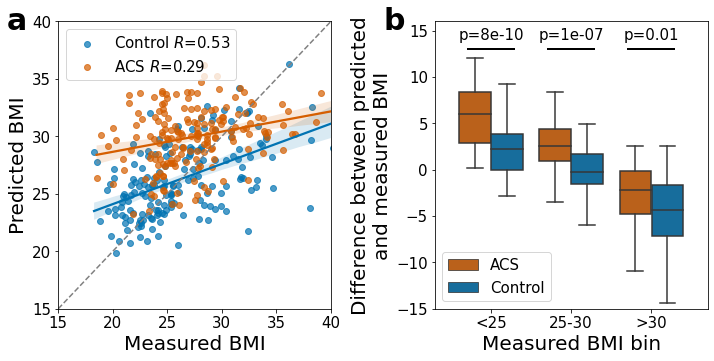

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['nightingale']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Control %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['nightingale']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=healthy_real_bmi.index.tolist() + acs_real_bmi.index.tolist(), columns=['x', 'y', 'z'])
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['nightingale']['bmi'].values - healthy_real_bmi.values
df.loc[healthy_real_bmi.index, 'x'] = y.values
df.loc[healthy_real_bmi.index, 'y'] = yy
df.loc[healthy_real_bmi.index, 'z'] = 'Control'
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['nightingale'].loc[:, 'bmi'].values - acs_real_bmi.values
df.loc[acs_real_bmi.index, 'x'] = y.values
df.loc[acs_real_bmi.index, 'y'] = yy
df.loc[acs_real_bmi.index, 'z'] = 'ACS'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
df = df.sort_values(['z', 'bin'])
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[acs_color, healthy_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-15, 16))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'Control') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'ACS') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 14,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=13, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')

# ax = axes[2]
# c = 'Glucose Disorder: DM2'
# data['bmi bin'] = pd.cut(data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
# sns.boxplot(x='bmi bin', y='acs bmi diffs', data=data.sort_values('bmi').replace({c:{0:'Normoglycemic', 1:'T2DM'}}), ax=ax, palette=colors, hue=c, showfliers=False)
# ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
# ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
# leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='')
# leg.get_title().set_fontsize(str(tick_fontsize))
# ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([-10, -5, 0, 5, 10, 15])
# add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)    
    
# ax = axes[3]
# c = 'Number of vessels involved: 1 vs 3'
# data['bmi bin'] = pd.cut(data.bmi, bmi_bins).astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
# sns.boxplot(x='bmi bin', y='acs bmi diffs', data=data.sort_values('bmi').replace({c:{0:'1', 1:'3'}}), ax=ax, palette=colors, hue=c, showfliers=False)
# ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
# ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
# leg = ax.legend(loc='lower left', fontsize=tick_fontsize, title='# vessels involved')
# leg.get_title().set_fontsize(str(tick_fontsize))
# ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([-10, -5, 0, 5, 10])
# add_text_at_corner(ax, 'OR=%0.2f (%0.2f-%0.2f), p=%0.1g'%(logit_results.loc[c, 'coef'], logit_results.loc[c, '0.025'], logit_results.loc[c, '0.975'] ,logit_results.loc[c, 'pval']), 'top left', fontsize=tick_fontsize)


fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
# plt.text(-0.15, 1.0, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')
# plt.text(-0.15, 1.0, 'd', ha='center', va='center', transform=axes[3].transAxes, fontsize=30, weight = 'bold')

# plt.savefig(os.path.join(gbdt_dir, 'Figure_v2_a-d_small.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(gbdt_dir, 'Figure_v2_a-d.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(gbdt_dir, 'Figure_v2_a-d.png'), dpi=1000, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_Nightingale_a-b.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_Nightingale_a-b.pdf'), dpi=300, bbox_inches='tight')

## Statins

In [1060]:

spearmanr(acs_pred_age_sex_bmi_dict['metabolon']['bmi'], acs_data.loc[acs_pred_age_sex_bmi_dict['metabolon']['bmi'].index.astype(str), 'Admission Statins'], nan_policy='omit')

SpearmanrResult(correlation=0.11537391051357837, pvalue=0.15284766486616144)

2530.0 0.04573649498768748


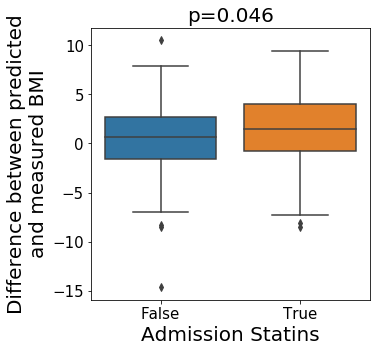

In [1085]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(x='Admission Statins', y='acs bmi diffs', data=acs_data, ax=ax)
ax.tick_params(labelsize=15)
ax.set_xticklabels(['False', 'True'])
ax.set_xlabel('Admission Statins', fontsize=20)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=20)
t, p = mannwhitneyu(acs_data[acs_data['Admission Statins']==1]['acs bmi diffs'].dropna(), acs_data[acs_data['Admission Statins']==0]['acs bmi diffs'].dropna())
# add_text_at_corner(ax, 'p=%0.2g'%p, 'bottom right', fontsize=15)
ax.set_title( 'p=%0.2g'%p, fontsize=20)
print (t, p)

In [1144]:
# healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].dropna()
# pnp_data_metabolon['DM'].loc[healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].dropna().index.astype(str)].sum()
# healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].reindex(pnp_data_metabolon[pnp_data_metabolon['DM']].index.astype(int)).dropna()
mannwhitneyu(df.reindex(pnp_data_metabolon[pnp_data_metabolon['DM']==1].index).dropna()['y'], df.reindex(pnp_data_metabolon[pnp_data_metabolon['DM']==0].index).dropna()['y'])

MannwhitneyuResult(statistic=332.0, pvalue=0.3253563613621822)

(80, 4)


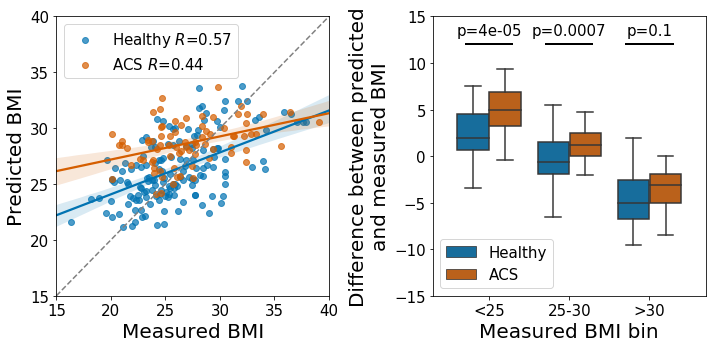

In [1119]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Healthy %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi.loc[acs_data['Admission Statins']==1], acs_pred_age_sex_bmi_dict['metabolon']['bmi'].loc[acs_data[acs_data['Admission Statins']==1].index.astype(int)]
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=healthy_real_bmi.index.tolist() + acs_real_bmi.index.tolist(), columns=['x', 'y', 'z'])
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi'].values - healthy_real_bmi.values
df.loc[healthy_real_bmi.index, 'x'] = y.values
df.loc[healthy_real_bmi.index, 'y'] = yy
df.loc[healthy_real_bmi.index, 'z'] = 'Healthy'
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon'].loc[:, 'bmi'].values - acs_real_bmi.values
df.loc[acs_real_bmi.index, 'x'] = y.values
df.loc[acs_real_bmi.index, 'y'] = yy
df.loc[acs_real_bmi.index, 'z'] = 'ACS'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
df = df.drop(acs_data[acs_data['Admission Statins']==0].index).dropna()
print (df[df['z']=='ACS'].shape)
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[healthy_color, acs_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-15, 15))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'Healthy') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'ACS') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 13,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=12, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')
    
fig.tight_layout()

In [1081]:
t, p = mannwhitneyu(acs_data[acs_data['Admission Statins']==1]['Age'].dropna(), acs_data[acs_data['Admission Statins']==0]['Age'].dropna())
print (t, p)

3232.0 5.365248177648175e-06


In [1153]:
t, p = mannwhitneyu(acs_data[acs_data['Admission Statins']==1]['Number of vessels involved: 1 vs 3'].dropna(), 
                    acs_data[acs_data['Admission Statins']==0]['Number of vessels involved: 1 vs 3'].dropna())
print (t, p)

1897.5 0.0005621774443482536


# Replication in MetaCardis

In [833]:
metacardis_dir = os.path.join('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'robust_zs_metabolomics/proc_metabolomics_clipped.csv')
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0)
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group']].copy()
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

{'hub.lipo.samples.v3.r', 'hub.serum_absolute.v1.samples.r', 'hub.urine_annotated.samples.v2.r', 'hub.serum_tmao.v1.samples.r'}


IHD372     269
HC275      225
MMC269     188
UMCC222    159
Name: Group, dtype: int64

In [875]:
metacardis_dir = os.path.join(curr_dir, 'metacardis')
make_dir_if_not_exists(metacardis_dir)
metacardis_dir = os.path.join(metacardis_dir, 'GBDT')
make_dir_if_not_exists(metacardis_dir)
metacardis_dir = os.path.join(metacardis_dir, 'Train-Test')
make_dir_if_not_exists(metacardis_dir)

# do 5-fold cross validation
# in each fold learn on the 4/5 healthy and predict the fold of healthy, and add age predictions to the acs as well.
models, healthy_pred_age_sex_bmi_dict, acs_pred_age_sex_bmi_dict, acs_Xs, healthy_Xs, healthy_shap_values_dic, acs_shap_values_dic = {}, {}, {}, {}, {}, {}, {}

for data_name, data_cols in zip(['nmr'], [metacardis_serum_metabolomics.columns.tolist()]):
    print (data_name)
    make_dir_if_not_exists(os.path.join(metacardis_dir, data_name))
    
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275') | (metacardis_X_age_bmi.Group == 'UMCC222')].copy()
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275') | (metacardis_X_age_bmi.Group == 'MMC269')].copy()
#     temp_X = metacardis_serum_metabolomics.loc[(metacardis_X_age_bmi.Group == 'HC275')].copy()
    temp_X = metacardis_serum_metabolomics.loc[metacardis_X_age_bmi.Group != 'IHD372'].copy()
    temp_X_acs = metacardis_serum_metabolomics.loc[metacardis_X_age_bmi.Group == 'IHD372'].copy()
    y_age = metacardis_X_age_bmi.loc[temp_X.index]['AGE'].dropna()
    y_bmi = metacardis_X_age_bmi.loc[temp_X.index]['BMI_C'].dropna()
    y_age_acs = metacardis_X_age_bmi.loc[temp_X_acs.index]['AGE'].dropna()
    y_bmi_acs = metacardis_X_age_bmi.loc[temp_X_acs.index]['BMI_C'].dropna()
    
    healthy_pred_age_sex_bmi = pd.DataFrame(np.nan, index=temp_X.index, columns=['AGE', 'BMI_C'])
    acs_pred_age_sex_bmi = pd.DataFrame(np.nan, index=temp_X_acs.index, columns=['AGE', 'BMI_C'])

    print ('healthy X', temp_X.shape, 'ACS X', temp_X_acs.shape)
    acs_Xs[data_name] = temp_X_acs.copy()
    healthy_Xs[data_name] = {}
    
    healthy_shap_values_dic[data_name] = {}
    acs_shap_values_dic[data_name] = {}
    
    models[data_name] = {}

    for target, X, y, mode in zip(['AGE', 'BMI_C'], 
                                  [temp_X.merge(y_age, on='SampleID').drop('AGE', axis=1),  # y_age[y_age>=40]
#                                    temp_X.merge(y_sex, on='RegistrationCode').drop('gender', axis=1), 
                                   temp_X.merge(y_bmi, on='SampleID').drop('BMI_C', axis=1)],
#                                   [temp_X.loc[y_age.index], temp_X.loc[y_sex.index], temp_X.loc[y_bmi.index]], 
                                  [temp_X.merge(y_age, on='SampleID')['AGE'], temp_X.merge(y_bmi, on='SampleID')['BMI_C']],  # y_age[y_age>=40]
                                  ['cont', 'cont']):
        healthy_Xs[data_name][target] = X.copy()
        
        acs_shap_values_dic[data_name][target] = pd.DataFrame(0, index=temp_X_acs.index, columns=temp_X_acs.columns)
        print (target, mode, X.shape)

#         train_idx, test_idx = train_test_split(X.index, test_size=temp_X_acs.shape[0], random_state=0)
        train_idx, test_idx = train_test_split(X.index, test_size=temp_X_acs.shape[0], random_state=0)
        X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
        print ('train-test shapes:', X_train.shape, X_test.shape)
        healthy_shap_values_dic[data_name][target] = pd.DataFrame(np.nan, index=X_test.index, columns=X_test.columns)

        if mode == 'cont':
            model = lgb.LGBMRegressor()
            rscv = RandomizedSearchCV(model, lightgbm_rscv_space, n_iter=5, cv=3)
#             x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
#             rscv.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='l2')
            rscv.fit(X_train.rename(columns={k:0 for k in X_train.columns}), y_train)

            y_pred = rscv.best_estimator_.predict(X_test)
            healthy_pred_age_sex_bmi.loc[X_test.index, target] = y_pred

            y_pred = rscv.best_estimator_.predict(temp_X_acs)
            acs_pred_age_sex_bmi.loc[temp_X_acs.index, target] = y_pred

            explainer = shap.TreeExplainer(rscv.best_estimator_)
            try:
                # changed on 3.10.2018, last column is the bias column
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)
            except:
                healthy_shap_values_dic[data_name][target].loc[X_test.index, :] = explainer.shap_values(X_test)[:, :-1]
                acs_shap_values_dic[data_name][target].loc[temp_X_acs.index, :] = explainer.shap_values(temp_X_acs)[:, :-1]

    
    healthy_pred_age_sex_bmi.to_csv(os.path.join(metacardis_dir, data_name, 'healthy_pred_age_sex_bmi.csv'))
    acs_pred_age_sex_bmi = acs_pred_age_sex_bmi.replace(0, np.nan)
    acs_pred_age_sex_bmi.to_csv(os.path.join(metacardis_dir, data_name, 'acs_pred_age_sex_bmi.csv'))
    healthy_pred_age_sex_bmi_dict[data_name] = healthy_pred_age_sex_bmi.copy()
    acs_pred_age_sex_bmi_dict[data_name] = acs_pred_age_sex_bmi.copy()
with open(os.path.join(metacardis_dir, 'models.pkl'), 'wb') as handle:
    pickle.dump(models, handle)
with open(os.path.join(metacardis_dir, 'acs_Xs.pkl'), 'wb') as handle:
    pickle.dump(acs_Xs, handle)
with open(os.path.join(metacardis_dir, 'healthy_Xs.pkl'), 'wb') as handle:
    pickle.dump(healthy_Xs, handle)
with open(os.path.join(metacardis_dir, 'acs_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(acs_shap_values_dic, handle)
with open(os.path.join(metacardis_dir, 'healthy_shap_values_dic.pkl'), 'wb') as handle:
    pickle.dump(healthy_shap_values_dic, handle)

nmr
healthy X (572, 222) ACS X (269, 222)
AGE cont (572, 222)
train-test shapes: (303, 222) (269, 222)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

BMI_C cont (570, 222)
train-test shapes: (301, 222) (269, 222)


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use i

nmr


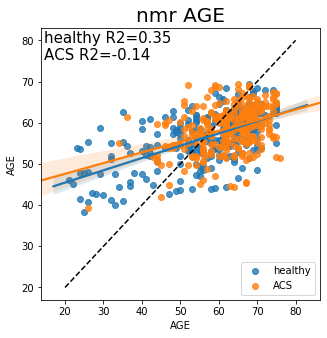

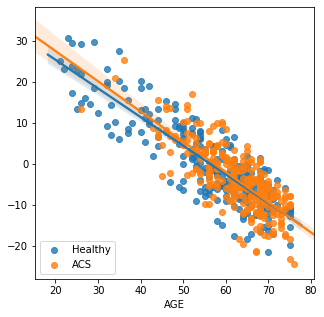

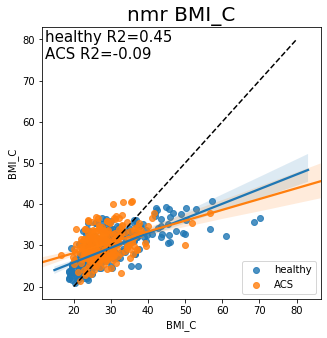

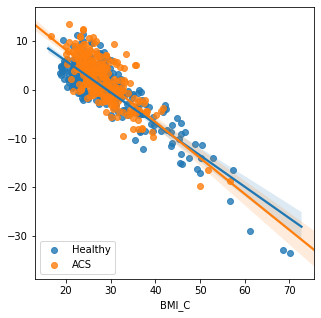

In [876]:
for data_name in healthy_pred_age_sex_bmi_dict:
    print (data_name)
    for target, healthy_y, acs_y in zip(['AGE', 'BMI_C'], [y_age, y_bmi], [y_age_acs, y_bmi_acs]):
        healthy_r2 = r2_score_rmna(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target].loc[healthy_y.index])
        acs_r2 = r2_score_rmna(acs_y, acs_pred_age_sex_bmi_dict[data_name][target].loc[acs_y.index])
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot([20, 80], [20, 80], '--', color='black')
        sns.regplot(healthy_y, healthy_pred_age_sex_bmi_dict[data_name][target].loc[healthy_y.index], label='healthy')
        sns.regplot(acs_y, acs_pred_age_sex_bmi_dict[data_name][target].loc[acs_y.index], label='ACS')
        add_text_at_corner(ax, 'healthy R2=%0.2f\nACS R2=%0.2f'%(healthy_r2, acs_r2), 'top left', fontsize=15)
        ax.set_title(data_name + ' ' + target, fontsize=20)
        ax.legend(loc='lower right')
        plt.show()
        
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        healthy_diffs = healthy_pred_age_sex_bmi_dict[data_name][target].loc[healthy_y.index].values - healthy_y.values
        acs_diffs = acs_pred_age_sex_bmi_dict[data_name][target].loc[acs_y.index].values - acs_y.values
        sns.regplot(healthy_y, healthy_diffs, label='Healthy')
        sns.regplot(acs_y, acs_diffs, label='ACS')
        ax.legend(loc='lower left')
        plt.show()

(0.70743746451569, 1.9094556717817797e-16)
(0.4237332265559852, 3.8024562911377635e-13)


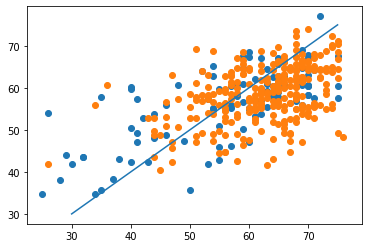

In [840]:
plt.scatter(y_age, healthy_pred_age_sex_bmi.loc[y_age.index, 'AGE'])
print (pearsonr_rmna(y_age, healthy_pred_age_sex_bmi.loc[y_age.index, 'AGE']))
plt.plot([30, 75], [30, 75])
plt.scatter(y_age_acs, acs_pred_age_sex_bmi.loc[y_age_acs.index, 'AGE'])
print (pearsonr_rmna(y_age_acs, acs_pred_age_sex_bmi.loc[y_age_acs.index, 'AGE']))

(0.695128629211962, 3.7379151700505795e-40)
(0.3893192268690288, 5.5212227500478956e-11)


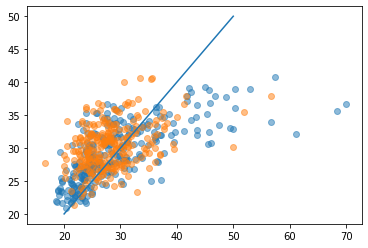

In [887]:
plt.scatter(y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C'], alpha=0.5)
print (pearsonr_rmna(y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C']))
plt.plot([20, 50], [20, 50])
plt.scatter(y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C'], alpha=0.5)
print (pearsonr_rmna(y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C']))

## plot

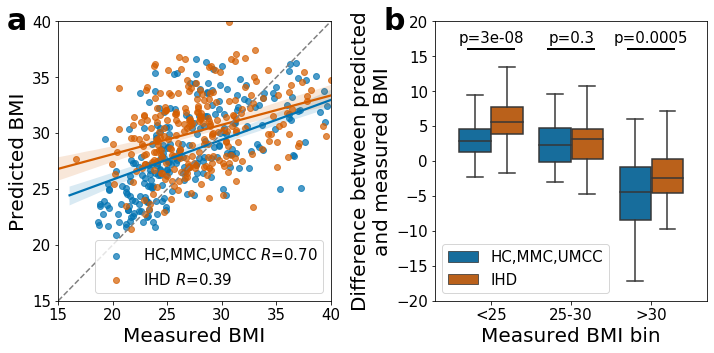

In [889]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
labels_fontsize = 20
tick_fontsize = 15
show_r2 = False
colors = sns.color_palette('Paired', 10)

if show_r2:
    method = r2_score_rmna
    r2_label = '$R^2$'
else:
    method = pearsonr_rmna_return_r
    r2_label = '$R$'

def pearsonr_rmna_return_r(x, y):
    return pearsonr_rmna(x, y)[0]

# age_bins = [35, 40, 50, 60, 70]
bmi_bins = [15, 25, 30, 55]

ax = axes[0]
y, yy = y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='HC,MMC,UMCC %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='IHD %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower right', fontsize=tick_fontsize)

ax = axes[1]
df = pd.DataFrame(index=y_bmi.index.tolist() + y_bmi_acs.index.tolist(), columns=['x', 'y', 'z'])
y, yy = y_bmi, healthy_pred_age_sex_bmi.loc[y_bmi.index, 'BMI_C'].values - y_bmi.values
df.loc[y_bmi.index, 'x'] = y.values
df.loc[y_bmi.index, 'y'] = yy
df.loc[y_bmi.index, 'z'] = 'HC,MMC,UMCC'
y, yy = y_bmi_acs, acs_pred_age_sex_bmi.loc[y_bmi_acs.index, 'BMI_C'].values - y_bmi_acs.values
df.loc[y_bmi_acs.index, 'x'] = y.values
df.loc[y_bmi_acs.index, 'y'] = yy
df.loc[y_bmi_acs.index, 'z'] = 'IHD'

df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['bin'] = pd.cut(df.x, bmi_bins)
df = df.sort_values(['z', 'bin'])
bmi_diff_bins = df.dropna().copy()
# bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(20, 25]':'<25', '(25, 30]':'25-30', '(30, 35]':'30-35', '(35, 40]':'>35'})
bmi_diff_bins['bin'] = bmi_diff_bins['bin'].dropna().astype(str).replace({'(15, 25]':'<25', '(25, 30]':'25-30', '(30, 55]':'>30'})
sns.boxplot(x='bin', y='y', data=bmi_diff_bins, hue='z', ax=ax, palette=[healthy_color, acs_color], showfliers=False)

ax.set_xlabel('Measured BMI bin', fontsize=labels_fontsize)
ax.set_ylabel('Difference between predicted\nand measured BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='lower left', fontsize=tick_fontsize)
ax.set_ylim((-20, 20))

for b, xx in zip(bmi_diff_bins['bin'].unique(), [0, 1, 2]):
    x, y = bmi_diff_bins[(bmi_diff_bins['z'] == 'HC,MMC,UMCC') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y'], bmi_diff_bins[(bmi_diff_bins['z'] == 'IHD') & (bmi_diff_bins['bin'].astype(str) == b)].dropna()['y']
    t, p = directed_mannwhitneyu(x, y)
    ax.text(xx, 17,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
    ax.hlines(y=16, xmin=xx-0.3, xmax=xx+0.3, linewidth=2, color='black')
    
fig.tight_layout()
plt.text(-0.15, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.15, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_MetaCardis_a-b_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(gbdt_dir, 'ExtendedDataFigure_MetaCardis_a-b.png'), dpi=1000, bbox_inches='tight')

In [754]:
k = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712'
# k = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus|fSGB__1413|gSGB__3421|sSGB__4540'
kp = pnp_data_metabolon.loc[:, metabolon_df.drop('SerumName', axis=1).columns].apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[1]).sort_values()
kr = pnp_data_metabolon.loc[:, metabolon_df.drop('SerumName', axis=1).columns].apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[0]).sort_values()

In [755]:
kp.head(20)

100006191    3.175276e-13
100001315    1.716249e-11
X - 23997    5.639439e-09
100000011    5.975804e-08
100001417    1.820313e-07
X - 11843    2.209536e-07
X - 11850    2.402672e-07
100004318    7.709209e-07
100000467    1.684842e-06
X - 21286    5.087958e-06
100006260    5.165819e-06
X - 24473    1.512964e-05
X - 11315    3.130919e-05
100002154    5.429269e-05
X - 12013    1.295826e-04
1258         1.801159e-04
100006108    2.206641e-04
100004541    2.273018e-04
X - 24811    5.674755e-04
100001403    6.070051e-04
dtype: float64

In [756]:
kr.loc[kp.head(20).index]

100006191   -0.326346
100001315   -0.302568
X - 23997   -0.263596
100000011   -0.245748
100001417   -0.236824
X - 11843   -0.235235
X - 11850   -0.234544
100004318   -0.224704
100000467   -0.217847
X - 21286   -0.207758
100006260   -0.207616
X - 24473    0.197300
X - 11315    0.190003
100002154    0.184291
X - 12013   -0.174896
1258        -0.171212
100006108   -0.168901
100004541    0.168561
X - 24811   -0.157737
100001403   -0.156912
dtype: float64

In [757]:
updated_metabs1.loc[kp.head(20).index]

,COMP_ID,Group HMDB_ID,Sample HMDB_ID,BIOCHEMICAL,CAS,CHEMSPIDER,KEGG,MASS,PATHWAY_SORTORDER,PLATFORM,PUBCHEM,RI,SUB_PATHWAY,SUPER_PATHWAY,COMMENT
100006191,48841,HMDB11686,NaN,p-cresol-glucuronide*,17680-99-8,135751.0,NaN,283.08232,175.0,LC/MS Neg,154035.0,2420.0,Tyrosine Metabolism,Amino Acid,p-cresol-glucuronide*
100001315,36103,HMDB11635,NaN,p-cresol sulfate,3233-57-7,3806480.0,NaN,187.00705,3560.0,LC/MS Neg,4615423.0,2890.0,Benzoate Metabolism,Xenobiotics,p-cresol sulfate
X - 23997,52025,NaN,NaN,X - 23997,NaN,NaN,NaN,223.07445,NaN,LC/MS Pos Early,NaN,1634.0,NaN,NaN,X - 23997
100000011,57745,HMDB00209,NaN,phenylacetate,103-82-2,10181341.0,C07086,91.05535,118.0,LC/MS Neg,999.0,2150.0,Phenylalanine Metabolism,Amino Acid,phenylacetate
100001417,35126,HMDB06344,NaN,phenylacetylglutamine,28047-15-6,270643.0,C04148,263.10373,865.0,LC/MS Neg,92258.0,2330.0,Acetylated Peptides,Peptide,phenylacetylglutamine
X - 11843,46466,NaN,NaN,X - 11843,NaN,NaN,NaN,230.01298,NaN,LC/MS Neg,NaN,2674.6,NaN,NaN,candidate structure is an aromatic amino acid ...
X - 11850,46507,NaN,NaN,X - 11850,NaN,NaN,NaN,226.01821,NaN,LC/MS Neg,NaN,3176.0,NaN,NaN,candidate structure is an aromatic amino acid ...
100004318,43374,NaN,NaN,indolin-2-one,59-48-3,284794.0,C12312,134.06004,3828.0,LC/MS Pos Early,321710.0,2575.0,Food Component/Plant,Xenobiotics,indolin-2-one
100000467,27672,HMDB00682,NaN,3-indoxyl sulfate,2642-37-7,9840.0,NaN,212.00230,241.0,LC/MS Neg,10258.0,2222.2,Tryptophan Metabolism,Amino Acid,3-indoxyl sulfate
X - 21286,46295,NaN,NaN,X - 21286,NaN,NaN,NaN,164.03550,NaN,LC/MS Neg,NaN,1550.0,NaN,NaN,candidate structure is pyridine related


In [758]:
unknowns_sp.reindex(kp.head(20).index).dropna().idxmax(1)

X - 23997      Benzoate Metabolism
X - 11843    Tryptophan Metabolism
X - 11850    Tryptophan Metabolism
X - 21286    Tryptophan Metabolism
X - 24473     Food Component/Plant
X - 11315     Food Component/Plant
X - 12013     Food Component/Plant
X - 24811      Xanthine Metabolism
dtype: object

In [759]:
circ_heatmap_df_sorted.reindex(kp.head(20).index).dropna()

,Healthy-ACS,Diabetes,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100006191,5.909900,1.291583,0.300000,0.004401,0.044332,0.000000
100001315,1.592100,0.453679,0.300000,0.004781,0.029797,0.000000
X - 23997,3.531587,0.812243,0.231620,0.000000,0.000000,0.000000
100000011,2.082481,1.480527,0.300000,0.002388,0.058230,0.000000
100001417,1.181786,1.858710,0.300000,0.000000,0.051203,0.000000
X - 11843,1.275782,-0.361893,0.300000,0.010518,0.000000,0.000000
X - 11850,0.370168,-0.473833,0.300000,0.010370,0.012585,0.000000
100004318,0.535355,-0.418603,0.180022,0.001333,0.003898,0.000000
100000467,0.568479,0.344718,0.132211,0.012965,0.000941,0.000000
X - 21286,1.042263,-0.494577,0.125909,0.011902,0.008752,0.000000


# Plots for presentation

In [890]:
pd.read_csv(os.path.join(curr_dir, 'GBDT', 'CV', 'metabolon+nightingale', 'healthy_pred_age_sex_bmi.csv', index_col=0)

[autoreload of LabData.DataLoaders.Loader failed: Traceback (most recent call last):
  File "/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 276, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


'/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/metabolomics_model_of_age_and_bmi'

In [919]:
temp_healthy_preds = pd.read_csv(os.path.join(curr_dir, 'GBDT', 'CV', 'metabolon', 'healthy_pred_age_sex_bmi.csv'), index_col=0)
temp_healthy_preds.index = temp_healthy_preds.index.astype(str)
pearsonr_rmna(healthy_real_age, temp_healthy_preds.loc[healthy_real_bmi.index, 'Age'])

(0.8430978347990671, 1.9317579540915518e-128)

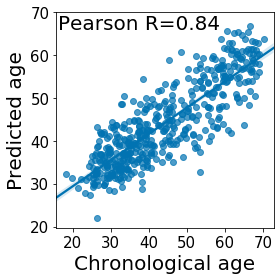

In [938]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.regplot(healthy_real_age, temp_healthy_preds.loc[healthy_real_age.index, 'Age'], color=healthy_color, scatter_kws={'alpha':0.7})
ax.set_xlabel('Chronological age', fontsize=20)
ax.set_ylabel('Predicted age', fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xticks(range(20, 75, 10))
ax.set_yticks(range(20, 75, 10))
r, p = pearsonr_rmna(healthy_real_age, temp_healthy_preds.loc[healthy_real_age.index, 'Age'])
add_text_at_corner(ax, 'Pearson R=%0.2f'%r, 'top left', fontsize=20)

fig.tight_layout()
plt.savefig(os.path.join(curr_dir, 'GBDT', 'CV', 'metabolon', 'age_predicted_vs_measured.png'), dpi=300, bbox_inches='tight')

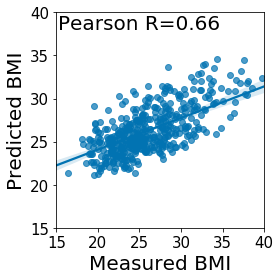

In [955]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.regplot(healthy_real_bmi, temp_healthy_preds.loc[healthy_real_bmi.index, 'bmi'], color=healthy_color, scatter_kws={'alpha':0.7})
ax.set_xlabel('Measured BMI', fontsize=20)
ax.set_ylabel('Predicted BMI', fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xticks(range(15, 45, 5))
ax.set_yticks(range(15, 45, 5))
r, p = pearsonr_rmna(healthy_real_bmi, temp_healthy_preds.loc[healthy_real_bmi.index, 'bmi'])
add_text_at_corner(ax, 'Pearson R=%0.2f'%r, 'top left', fontsize=20)

fig.tight_layout()
plt.savefig(os.path.join(curr_dir, 'GBDT', 'CV', 'metabolon', 'bmi_predicted_vs_measured.png'), dpi=300, bbox_inches='tight')

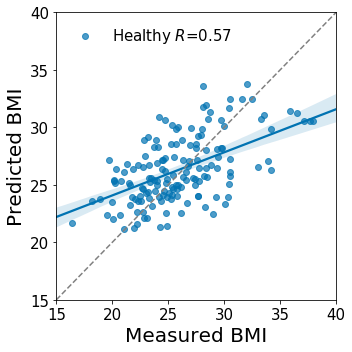

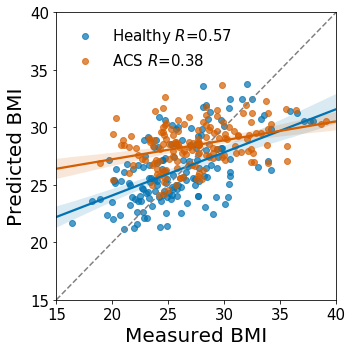

In [981]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Healthy %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
# y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']
# r2 = method(y, yy)
# sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)

fig.tight_layout()
plt.savefig(os.path.join(gbdt_dir, 'measured_vs_predicted_bmi-healthy.png'), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
y, yy = healthy_real_bmi, healthy_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=healthy_color, label='Healthy %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
y, yy = acs_real_bmi, acs_pred_age_sex_bmi_dict['metabolon']['bmi']
r2 = method(y, yy)
sns.regplot(y, yy, color=acs_color, label='ACS %s=%0.2f'%(r2_label, r2), ax=ax, scatter_kws={'alpha':0.7})
ax.plot([15, 40], [15, 40], '--', color='grey')
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))
ax.set_xlabel('Measured BMI', fontsize=labels_fontsize)
ax.set_ylabel('Predicted BMI', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)

fig.tight_layout()
plt.savefig(os.path.join(gbdt_dir, 'measured_vs_predicted_bmi-healthy+acs.png'), dpi=300, bbox_inches='tight')